In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
sns.set(font_scale=1.5)

**************************************************

Baseline param sweep -- large goods

**************************************************

In [2]:
dfpairs = pd.read_csv("param_sweep_pairs.csv")
dfpairs['NRecovered'] = dfpairs['FracRecovered']*dfpairs['NStaff']
print(dfpairs.columns,'\n')

Index(['Group', 'NStaff', 'Iteration', 'FracRecovered',
       'TotInfPackagesDelivered', 'FomiteInfectionFrac',
       'NetworkInfectionFrac', 'ContactInfectionFrac', 'PairInfectionFrac',
       'RoomInfectionFrac', 'ExtIntroFrac', 'CustIntroFrac',
       'CustomersInfectedByPkg', 'CustomersInfectedByDrivers', 'IsolatorsFrac',
       'SympIsolatorsFrac', 'FPIsolatorsFrac', 'TPSympIsolatorsFrac',
       'TPAsympIsolatorsFrac', 'IndexCaseInfections', 'IndexCaseViralLoad',
       'IndexCaseInfectivity', 'OverallOutbreakLength', 'fixed_loader_pairs',
       'Dtime', 'Ltime', 'fixed_driver_pairs', 'tD', 'SimType', 'PkgHlife',
       'p_friend_contact', 'phi', 'is_driver_pairs', 'InfInit', 'Pisol',
       'is_loader_pairs', 'p_contact', 'p_fomite_contr', 'p_fomite_trans',
       'is_window_open', 'pair_isolation', 'NRecovered'],
      dtype='object') 



In [3]:
II = np.unique(dfpairs["InfInit"])
TD = np.unique(dfpairs["tD"])
FP = np.unique(dfpairs["fixed_driver_pairs"])
WO = np.unique(dfpairs["is_window_open"])
PI = np.unique(dfpairs["pair_isolation"])

#parameter reminder
print('Phi = ', np.unique(dfpairs['phi']))
print('Pisol = ', np.unique(dfpairs['Pisol']))
print('Random contact rate = ', np.unique(dfpairs['p_contact']))
print('Friend contact prob = ', np.unique(dfpairs['p_friend_contact']))
print('Staff totals = ', np.unique(dfpairs['NStaff']))

Phi =  [0.05]
Pisol =  [0.5]
Random contact rate =  [0.04545455]
Friend contact prob =  [1.]
Staff totals =  [ 8 16 20 44]


breakdown of infection causes in the model

In [4]:
job = ['Driver','Picker','Office']
jobtypes = np.unique(dfpairs['Group'])
netinfs = np.zeros((len(jobtypes),len(TD),len(II),len(FP),len(WO),len(PI)))
continfs = np.zeros((len(jobtypes),len(TD),len(II),len(FP),len(WO),len(PI)))
roominfs = np.zeros((len(jobtypes),len(TD),len(II),len(FP),len(WO),len(PI)))
pairinfs = np.zeros((len(jobtypes),len(TD),len(II),len(FP),len(WO),len(PI)))

for (n, g) in enumerate(jobtypes):
    dfg = dfpairs.loc[lambda dfpairs: (dfpairs['Group'] == g)]
    for (i,td) in enumerate(TD):
        dfi =  dfg.loc[lambda dfg: (dfg['tD'] == td)]
        for (j,ii) in enumerate(II):
            dfij =  dfi.loc[lambda dfi: (dfi['InfInit'] == ii)]
            for (k,fp) in enumerate(FP):
                dfijk =  dfij.loc[lambda dfij: (dfij['fixed_driver_pairs'] == fp)]
                for (l,wo) in enumerate(WO):
                    dfijkl = dfijk.loc[lambda dfijk: (dfijk['is_window_open'] == wo)]
                    for (m,pi) in enumerate(PI):
                        dfijklm = dfijkl.loc[lambda dfijkl: (dfijkl['pair_isolation'] == pi)]
                        netinfs[n,i,j,k,l,m] = np.mean(dfijklm['NetworkInfectionFrac']\
                                                      *dfijklm['NStaff'])
                        continfs[n,i,j,k,l,m] = np.mean(dfijklm['ContactInfectionFrac']\
                                                      *dfijklm['NStaff'])
                        roominfs[n,i,j,k,l,m] = np.mean(dfijklm['RoomInfectionFrac']\
                                                      *dfijklm['NStaff'])
                        pairinfs[n,i,j,k,l,m] = np.mean(dfijklm['PairInfectionFrac']\
                                                      *dfijklm['NStaff'])
                        
# for (i,td) in enumerate(TD):
#     for (j,ii) in enumerate(II):
#         for (k,fp) in enumerate(FP):
#             for (l,wo) in enumerate(WO):
#                 for (m,pi) in enumerate(PI):                        
#                     norm = netinfs[jobtypes=='All',i,j,k,l,m][0] + \
#                             continfs[jobtypes=='All',i,j,k,l,m][0] + \
#                             roominfs[jobtypes=='All',i,j,k,l,m][0] + \
#                             pairinfs[jobtypes=='All',i,j,k,l,m][0]
#                     if norm > 0:
#                         netinfs[:,i,j,k,l,m] /= norm
#                         continfs[:,i,j,k,l,m] /= norm
#                         roominfs[:,i,j,k,l,m] /= norm
#                         pairinfs[:,i,j,k,l,m] /= norm

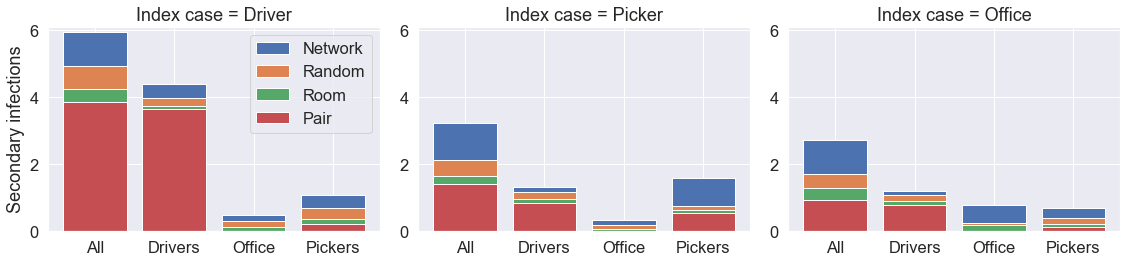

In [5]:
fig,ax = plt.subplots(1,3,figsize=(16,4))  
for j in np.arange(3):
    k,l,m = 0,0,0
    ax[j].bar(jobtypes, netinfs[:,2,j,k,l,m]+continfs[:,2,j,k,l,m]+\
                      roominfs[:,2,j,k,l,m]+pairinfs[:,2,j,k,l,m],label='Network')
    ax[j].bar(jobtypes, continfs[:,2,j,k,l,m]+\
                          roominfs[:,2,j,k,l,m]+pairinfs[:,2,j,k,l,m],label='Random')
    ax[j].bar(jobtypes, roominfs[:,2,j,k,l,m]+pairinfs[:,2,j,k,l,m],label='Room')
    ax[j].bar(jobtypes, pairinfs[:,2,j,k,l,m],label='Pair')
    ax[j].set_ylim((0,6.1))
    
        
    ax[j].set_title('Index case = %s'%job[j])
ax[0].set_ylabel('Secondary infections')
ax[0].legend()
fig.tight_layout()
fig.savefig('pair_infection_routes.png')

In [6]:
dfall = dfpairs[dfpairs["Group"]=='All']

dfall["Scenario"] = np.zeros(len(dfall),dtype=np.object)
dfall.loc[lambda dfall: ((dfall['fixed_driver_pairs'] == False) & \
                        (dfall['pair_isolation'] == False) & \
                        (dfall['is_window_open'] == False)), 'Scenario'] = "No intervention"
dfall.loc[lambda df: ((df['fixed_driver_pairs'] == True) & \
                     (df['pair_isolation'] == True) & \
                     (df['is_window_open'] == False)), 'Scenario'] = "Fixed pairings"
dfall.loc[lambda df: ((df['fixed_driver_pairs'] == False) & \
                      (df['pair_isolation'] == False) & \
                      (df['is_window_open'] == True)),'Scenario'] = "Windows open"
dfall.loc[lambda df: ((df['fixed_driver_pairs'] == True) & \
                      (df['pair_isolation'] == True) & \
                      (df['is_window_open'] == True)),'Scenario'] = "FP + WO"

dfall['outbreak'] = (dfall['NRecovered'] > 3)
dfall['Ninfected'] = (dfall.loc[:,'FracRecovered']*dfall.loc[:,'NStaff'] - 1)
dfreduced = dfall.loc[dfall["Scenario"] != 0,:]

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set

        

Index case to outbreak relation

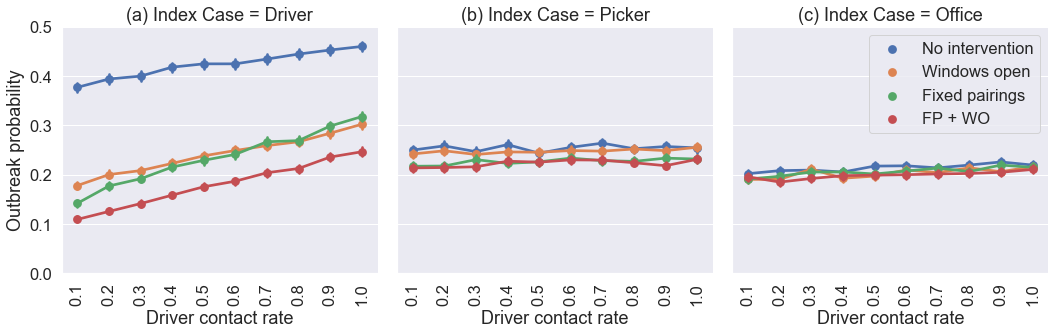

In [7]:
sns.set_color_codes()
sp = sns.catplot(x='tD',y='outbreak', hue='Scenario',col='InfInit',data=dfreduced,kind='point',
                 hue_order=['No intervention','Windows open','Fixed pairings','FP + WO'],
                 legend=False)
sp.set(ylim=(0,0.5),xlabel='Driver contact rate')
axes = sp.axes.flatten()
axes[0].set_ylabel('Outbreak probability')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp.set_xticklabels(rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()
sp.savefig('Outbreak_prob_pairs.png')

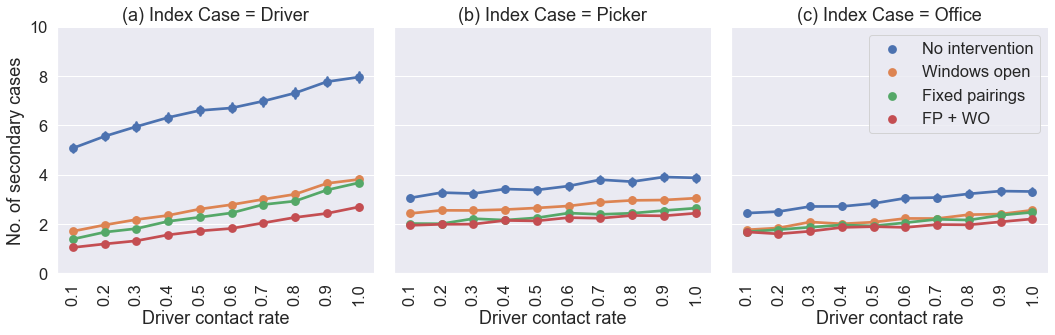

In [8]:
sns.set_color_codes()
sp = sns.catplot(x='tD',y='Ninfected', hue='Scenario',col='InfInit',data=dfreduced,kind='point',
                 hue_order=['No intervention','Windows open','Fixed pairings','FP + WO'],legend=False)
sp.set(ylim=(0,10),xlabel='Driver contact rate')
axes = sp.axes.flatten()
axes[0].set_ylabel('No. of secondary cases')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp.set_xticklabels(rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()
sp.savefig('Secondary_infections_pairs.png')

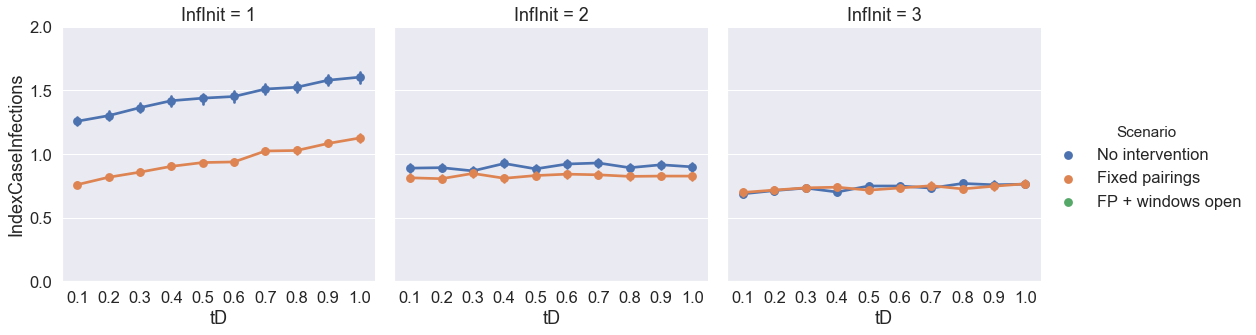

In [9]:
figh = sns.catplot(x='tD',y='IndexCaseInfections',col='InfInit',hue='Scenario',data=dfreduced,\
                   hue_order=['No intervention','Fixed pairings','FP + windows open'],kind='point')
figh.set(ylim=(0,2))

customer infections

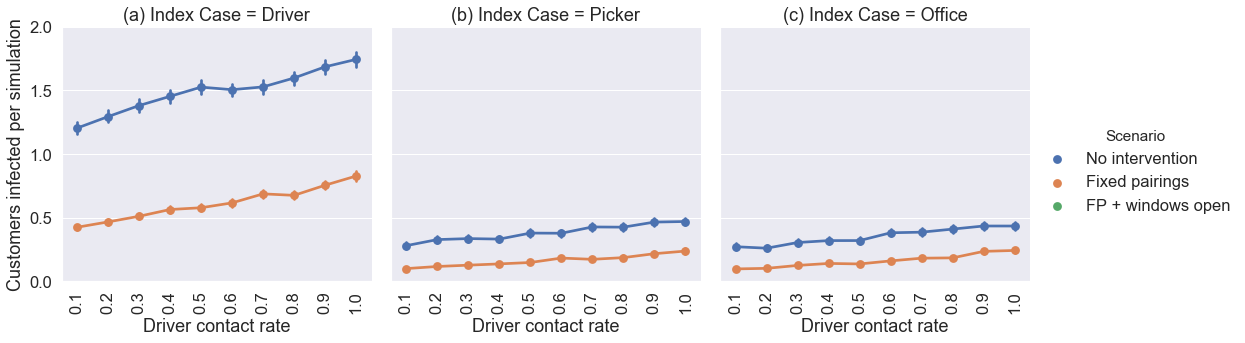

In [10]:
sp = sns.catplot(x='tD',y='CustomersInfectedByDrivers',col='InfInit',hue='Scenario',\
                 data=dfreduced, kind='point', \
                 hue_order=['No intervention','Fixed pairings','FP + windows open'])
sp.set(ylim=(0,2.0),xlabel='Driver contact rate')
axes = sp.axes.flatten()
axes[0].set_ylabel('Customers infected per simulation')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp._legend.set_title('Scenario')
sp.set_xticklabels(rotation=90)
sp.savefig('Customer_infections_pairs.png')